### Yelp capstone project part 3: 
Extract review text of AZ restaurants between 2016 and 2018. 
To generate labels, I consider that review is positive when the restaurants received above 4 stars.
Three methods were used to construct numerical representation of text.

Method 3: term frequency + inverse document frequency. 


**1. load data and down sample using 10% of original data**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/My Drive/Colab Notebooks/yelp

/content/gdrive/My Drive/Colab Notebooks/yelp


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [0]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/yelp/last_2_years_restaurant_reviews_AZ.csv')

In [0]:
df.shape

(462965, 13)

In [0]:
# ufo.sample(frac=0.75, random_state=99)

df = df.sample(frac=0.1, random_state=0)

print("sampling 0.1 data:")
df.shape

sampling 0.1 data:


(46296, 13)

In [0]:
df.head(3)

,business_id,Unnamed: 0,name,categories,starts_business,cool,date,funny,review_id,stars,text,useful,user_id
114410,EEGajOchS2BIZNvJcPK3uw,4922,Crudo,"Italian, Nightlife, American (Traditional), Re...",4.5,0,2018-05-31,0,JooJun7aUGOrVnkXWjywnw,1,I have been so excited to try Crudo. What a di...,0,7VNGBCqrd9JdhFlMWtEeMA
164615,LBAkHJJfCoDj9aa5sc0Mxw,1041,Steak 'n Shake,"American (Traditional), Food, Burgers, Steakho...",2.5,0,2018-02-11,0,EZjy26BxRdooJWNrwQYlLw,1,If you have ever been to a 'real' Steak 'n Sha...,0,AHxMjZ0AXH_4meB7toaGlw
313571,f30-DOoIxvoV9btiDvKMTw,4686,Joe's Midnight Run,"Nightlife, Bars, Restaurants, American (New)",4.0,0,2018-02-25,0,ZopiO_mcaEU3-puOqrlcAg,4,It's a small place but they have good food. Wh...,0,reUMLWwXDGiyUJWm-zQ7QA


Text(0, 0.5, 'counts')

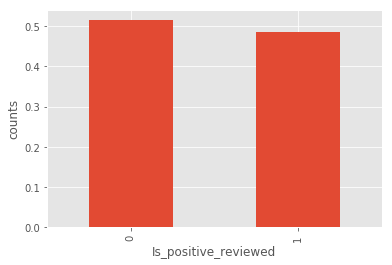

In [0]:
df.rename(columns={'stars':'stars_review'}, inplace=True)
df['positive_review'] = df['stars_review'] >4
df['positive_review'] = df['positive_review'].apply(lambda x: '1' if x is True else '0')
df['positive_review'] = df['positive_review'].astype(int)

df['positive_review'].value_counts(normalize=True).plot(kind='bar')
plt.xlabel("Is_positive_reviewed")
plt.ylabel("counts")

In [0]:
df = df[['positive_review', 'text']]
df.shape

(46296, 2)

In [0]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

TEXT_CLEANING_RE = '@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+'

def prepress(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if stem:
            tokens.append(stemmer.stem(token))
        else:
            tokens.append(token)
    return " ".join(tokens)

In [0]:
df.text = df.text.apply(lambda x: prepress(x))

**2. Numerical representation of Text method 2:**
#### tf-idf

In [0]:
#1. prepare documents
documents = df['text']

# get non Null index
indx = pd.notnull(documents)

# select review that is not null
documents = documents[indx].values

# print first 5 documents
documents[:5]

array(['i have been so excited to try crudo what a disappointment everything is so over salted it is hardly eatable i will not return not good enough for a second chance',
       'if you have ever been to a real steak n shake then don t go this restaurant burgers are not as good as all other locations they try to wrap the burgers like in and out burgers not sure why if you order the double it is so flimsy it looks just like a single',
       'it s a small place but they have good food when it first opened i was into grilled octopus and had to try it it was good but thought it was a bit pricey we were told to try their flat iron steak so we did it was so juicy and tasty that we look foward to going there just for that we also tried their pork chop it was good but would have been better if it was cooked right the first time they took it back cooked it a longer and it got slightly dried but still good great service manager came by to make sure we were happy',
       'the past four times i

In [0]:
#2. prepare label
target = df['positive_review'].values

# only select 'stars' that have review
target = target[indx]

# print first 5 review label
target[:5]

array([0, 0, 0, 0, 1])

In [0]:
#3. review and target label should have the same size
documents.size, target.size

(46296, 46296)

**3. review text vectorization**

In [0]:
# split train and test dataset
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

documents_train,documents_test,target_train,target_test = train_test_split(documents,target,test_size=0.3, random_state=0)

In [0]:
# single gram
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english',max_features=5000,min_df=1)

# model training
X_train = vectorizer.fit_transform(documents_train).toarray()

# get tfidf
features_name = vectorizer.get_feature_names()

# let model to transform test dataset
X_test = vectorizer.transform(documents_test).toarray()

In [0]:
# CountVectorizer - count vector
# TfidfVectorizer - word frequency vectors
# HashingVectorizer - unique integers 

In [0]:
# bigram

vectorizer2 = TfidfVectorizer(stop_words='english',max_features=5000,min_df=1,ngram_range=(1, 2))
X_train2 = vectorizer2.fit_transform(documents_train).toarray()
features_name2 = vectorizer2.get_feature_names()
X_test2 = vectorizer2.transform(documents_test).toarray()

**4. search for similar review text**

In [0]:
# generate function that return top and bottom values
import numpy as np


def get_top_values(lst, n, labels):
    return [labels[i] for i in np.argsort(lst)[::-1][:n]]  

def get_bottom_values(lst, n, labels):
    return [labels[i] for i in np.argsort(lst)[:n]]

In [0]:
# Draw an arbitrary review from test (unseen in training) documents
sample_review = [documents_test[10]]
sample_review

['the staff was very pleasant and friendly i ordered the special which was 3 eggs scrambled with jalape o sausage and cheese with a dude of homestyle potatoes the eggs were still runny and sausages didn t even seem to be cooked all the way the potatoes were still hard its likely i won t order from there again what a waste of 16 i work in the building next store and would rather drive somewhere else than eat that food again']

In [0]:
# Transform the drawn review(s) to vector(s)
vector_review = vectorizer.transform(sample_review).toarray()

vector_review2 = vectorizer2.transform(sample_review).toarray()

In [0]:
# Calculate the similarity score between vector and training vectors
from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = cosine_similarity(vector_review, X_test[:100])

print(similarity_scores[0])

[0.         0.02895703 0.02432764 0.         0.04684344 0.02728223
 0.00502791 0.03032702 0.00631917 0.03989682 1.         0.01975957
 0.03130375 0.02076141 0.01725164 0.         0.06843275 0.
 0.04064754 0.         0.03897373 0.         0.07639302 0.01625296
 0.         0.02637558 0.0479126  0.09887902 0.00611086 0.01228449
 0.00598159 0.01716517 0.03402372 0.         0.01424784 0.
 0.         0.01997436 0.04502855 0.02713927 0.02671827 0.
 0.         0.01621121 0.02894157 0.02559106 0.01658571 0.
 0.         0.00595082 0.01286663 0.05710259 0.00883638 0.01625668
 0.         0.         0.0176439  0.01251369 0.00476802 0.
 0.01272929 0.         0.06039578 0.01532529 0.         0.01371691
 0.         0.01656012 0.02450143 0.01857473 0.03154731 0.00360263
 0.01386504 0.         0.02958156 0.         0.03695558 0.01460452
 0.01698476 0.04044699 0.03086218 0.         0.0220706  0.004742
 0.0148572  0.00729918 0.05017218 0.         0.01858226 0.04695168
 0.02135772 0.00597924 0.         0.0

In [0]:
similarity_scores2 = cosine_similarity(vector_review2,X_test2[:100])
print(similarity_scores2[0])

[0.         0.02819006 0.02213457 0.         0.04445981 0.02346744
 0.00457261 0.02897874 0.00517924 0.0388837  1.         0.01737253
 0.03085428 0.01556661 0.01549129 0.         0.06045345 0.
 0.04009314 0.         0.02654554 0.         0.06454216 0.01546963
 0.         0.02242827 0.04607674 0.11452751 0.00579736 0.01346342
 0.00445876 0.01440111 0.03185147 0.         0.01406963 0.
 0.         0.02359544 0.04606379 0.02494124 0.02151199 0.
 0.         0.01413853 0.0248759  0.02639595 0.01647592 0.
 0.         0.0038596  0.01215442 0.03504691 0.00691308 0.0171118
 0.         0.         0.01660785 0.01052644 0.00448751 0.
 0.01254052 0.         0.05346341 0.01516472 0.         0.01239096
 0.         0.01574619 0.02429017 0.01869452 0.03323251 0.0032724
 0.01369181 0.         0.02793455 0.         0.03173497 0.01232663
 0.01526793 0.03851932 0.02318429 0.         0.02081722 0.00453435
 0.01277747 0.00789388 0.05060582 0.         0.01948754 0.04549486
 0.01465474 0.00419952 0.         0.0

In [0]:
# identify top 5 similar review
n = 5
top_similar_review = get_top_values(similarity_scores[0], n, documents_test[:100])

In [0]:
n = 5
top_similar_review2 = get_top_values(similarity_scores2[0],n,documents_test[:100])

In [0]:
print('Our search query:')
print(sample_review) 

Our search query:
['the staff was very pleasant and friendly i ordered the special which was 3 eggs scrambled with jalape o sausage and cheese with a dude of homestyle potatoes the eggs were still runny and sausages didn t even seem to be cooked all the way the potatoes were still hard its likely i won t order from there again what a waste of 16 i work in the building next store and would rather drive somewhere else than eat that food again']


In [0]:
print('Most %s similar reviews:' % n)
for i in range(len(top_similar_review)):
    print ('top %s review:' % i)
    print (top_similar_review[i])

Most 5 similar reviews:
top 0 review:
the staff was very pleasant and friendly i ordered the special which was 3 eggs scrambled with jalape o sausage and cheese with a dude of homestyle potatoes the eggs were still runny and sausages didn t even seem to be cooked all the way the potatoes were still hard its likely i won t order from there again what a waste of 16 i work in the building next store and would rather drive somewhere else than eat that food again
top 1 review:
we tried the oysters beef cheeks with bone marrow ribeye wagyu steak green chili mashed potatoes crushed potatoes with pancetta and the mousse dome the beef cheeks with marrow were delicious the oysters were pretty tiny steaks were seasoned very well the view was nice but it does depend on which booth you get also even though it may seem private you are divided by a curtain so you can hear the conversations next to you pretty clearly we ordered the mousse to go which did not hold up well we wish the server would have 

In [0]:
print('Most %s similar reviews:' % n)
for i in range(len(top_similar_review2)):
    print ('top %s review:' % i)
    print (top_similar_review2[i])

Most 5 similar reviews:
top 0 review:
the staff was very pleasant and friendly i ordered the special which was 3 eggs scrambled with jalape o sausage and cheese with a dude of homestyle potatoes the eggs were still runny and sausages didn t even seem to be cooked all the way the potatoes were still hard its likely i won t order from there again what a waste of 16 i work in the building next store and would rather drive somewhere else than eat that food again
top 1 review:
we tried the oysters beef cheeks with bone marrow ribeye wagyu steak green chili mashed potatoes crushed potatoes with pancetta and the mousse dome the beef cheeks with marrow were delicious the oysters were pretty tiny steaks were seasoned very well the view was nice but it does depend on which booth you get also even though it may seem private you are divided by a curtain so you can hear the conversations next to you pretty clearly we ordered the mousse to go which did not hold up well we wish the server would have 

***conclusion: single gram and bi gram produce every similar results of document searching***

**5. classification modeling**

In [0]:
print("use tf-idf from single gram")
print("train set size is: ", X_train.shape, target_train.shape)
print("test set size is: ", X_test.shape, target_test.shape)


use tf-idf from single gram
train set size is:  (32407, 5000) (32407,)
test set size is:  (13889, 5000) (13889,)


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

 
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

def train_test_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

***5.1 Logistic regression***

              train      test
metrics                      
AUC        0.934585  0.908815
Accuracy   0.862406  0.825905
Precision  0.847842  0.809565
Recall     0.874929  0.834978
f1-score   0.861173  0.822075


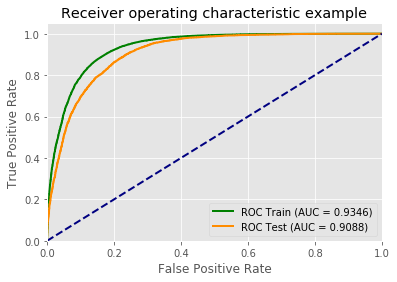

CPU times: user 3.55 s, sys: 517 ms, total: 4.07 s
Wall time: 3.19 s


In [0]:
%%time
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1.0, penalty='l2')

LRmodel = clf.fit(X_train, target_train)

train_test_model(clf, X_train, target_train, X_test, target_test)

In [0]:
# find key words that contribute to positive review
n = 20
get_top_values(LRmodel.coef_[0], n, features_name)

['amazing',
 'best',
 'delicious',
 'thank',
 'favorite',
 'great',
 'awesome',
 'fantastic',
 'love',
 'incredible',
 'highly',
 'excellent',
 'wonderful',
 'perfect',
 'gem',
 'outstanding',
 'perfectly',
 'owner',
 'glad',
 'perfection']

In [0]:
# find key words that contribute to negative review
n = 20
get_bottom_values(LRmodel.coef_[0], n, features_name)

['rude',
 'ok',
 'bland',
 'horrible',
 'mediocre',
 'worst',
 'disappointing',
 'terrible',
 'okay',
 'slow',
 'average',
 'wasn',
 'pretty',
 'decent',
 'dry',
 'reason',
 'didn',
 'unfortunately',
 'overall',
 'bad']

***5.2 Random forest***

              train      test
metrics                      
AUC        0.868841  0.855633
Accuracy   0.788811  0.780906
Precision  0.768241  0.757957
Recall     0.811982  0.800897
f1-score   0.789506  0.778836


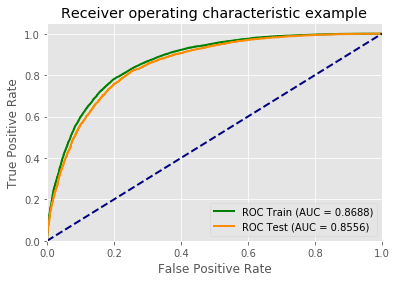

CPU times: user 1min 49s, sys: 801 ms, total: 1min 50s
Wall time: 57.4 s


In [0]:
%%time
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators': 50,
              'max_features': 'auto',
              'criterion': 'gini',
              'max_depth': 20,
              'min_samples_split': 5,
              'min_samples_leaf': 40,
              'random_state': 0,
              'n_jobs': -1}

clf = RandomForestClassifier(**parameters)



rfmodel = clf.fit(X_train, target_train)

train_test_model(clf, X_train, target_train, X_test, target_test)

In [0]:
# find key words that contribute to positive review
n = 20
get_top_values(rfmodel.feature_importances_, n, features_name)

['great',
 'best',
 'amazing',
 'delicious',
 'love',
 'ordered',
 'didn',
 'awesome',
 'minutes',
 'favorite',
 'asked',
 'wasn',
 'definitely',
 'order',
 'ok',
 'like',
 'bad',
 'horrible',
 'terrible',
 'worst']

In [0]:
# find key words that contribute to negative review
n = 20
get_bottom_values(rfmodel.feature_importances_, n, features_name)

['ladies',
 'pick',
 'piccata',
 'pic',
 'phx',
 'photos',
 'photo',
 'picked',
 'phones',
 'philly',
 'pf',
 'petite',
 'peter',
 'pete',
 'pet',
 'pho',
 'picking',
 'pickle',
 'pickled',
 'piled']

***5.3 Gradient boost***

              train      test
metrics                      
AUC        0.916214  0.877629
Accuracy   0.831796  0.794586
Precision  0.821495  0.780770
Recall     0.837034  0.797459
f1-score   0.829192  0.789026


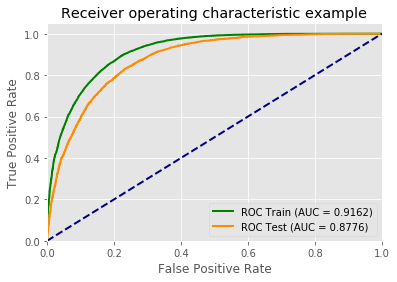

CPU times: user 26min 55s, sys: 2.45 s, total: 26min 57s
Wall time: 26min 57s


In [0]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

parameters = {
    'n_estimators': 50,
    'max_depth': 5,
    'learning_rate': 0.2,
    'random_state': 42
}


clf = GradientBoostingClassifier(**parameters)

train_test_model(clf, X_train, target_train, X_test, target_test)

***5.4 naive bayes***

In [0]:
%%time
from sklearn.naive_bayes import MultinomialNB

clf_nb = MultinomialNB()

clf_nb.fit(x_train, target_train)

train_test_model(clf_nb, X_train, target_train, X_test, target_test)

***5.5 Feedforward neural network***

              train      test
metrics                      
AUC        0.500000  0.500000
Accuracy   0.512235  0.518324
Precision  0.000000  0.000000
Recall     0.000000  0.000000
f1-score   0.000000  0.000000


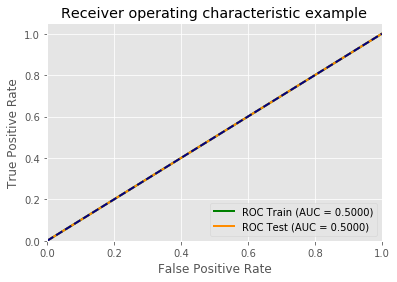

CPU times: user 1min 3s, sys: 7.87 s, total: 1min 11s
Wall time: 39.9 s


In [0]:
%%time
from sklearn.neural_network import MLPClassifier


parameters = {
    'solver':'adam', 
    'activation':'relu',
    'alpha':1e-5, 
    'hidden_layer_sizes':(5,5), 
    'learning_rate':'adaptive',
    'random_state':1
    }

ffnn = clf = MLPClassifier(**parameters)

train_test_model(ffnn, X_train, target_train, X_test, target_test)

              train      test
metrics                      
AUC        0.775086  0.768264
Accuracy   0.623199  0.622723
Precision  0.571673  0.567492
Recall     0.907256  0.911211
f1-score   0.701391  0.699403


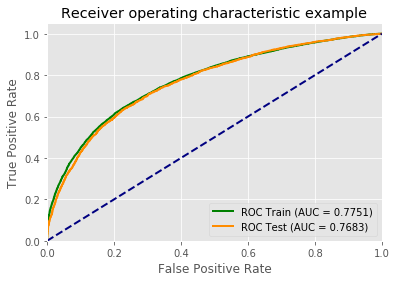

CPU times: user 18min 23s, sys: 396 ms, total: 18min 23s
Wall time: 18min 23s


In [0]:
%%time

from sklearn.svm import SVC

parameters = {'probability':True, 
    'max_iter':200}
    
svc = clf = SVC(**parameters)    

train_test_model(svc, X_train, target_train, X_test, target_test)